In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, losses, metrics, optimizers, datasets
from tensorflow.data import Dataset
from IPython import display as ipd

In [3]:
ETA = 1e-3
EPOCHS = 100
BATCH_SIZE = 128

In [4]:
trainset, testset = datasets.mnist.load_data()

In [5]:
trainloader = Dataset.from_tensor_slices(trainset).batch(BATCH_SIZE).shuffle(1024)
testloader = Dataset.from_tensor_slices(testset).batch(BATCH_SIZE)

## Conditional GANs

In [6]:
class Generator(models.Model):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.generator = models.Sequential([
            layers.Conv2DTranspose(128, (4, 4), strides=1, padding="valid", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(1, (3, 3), strides=2, padding="same", output_padding=1),
            layers.Activation(tf.nn.sigmoid)
        ])
        
    def call(self, z, y, training=False):
        N = y.shape[0]
        
        z = tf.reshape(z, shape=(N, 1, 1, -1))
        y = tf.reshape(y, shape=(N, 1, 1, 1))
        y = tf.tile(y, [1, 1, 1, 128])
        
        latent = tf.concat([z, y], axis=-1)
        samples = self.generator(latent, training=training)
        
        return samples

In [7]:
class Discriminator(models.Model):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.discriminator = models.Sequential([
            layers.Conv2D(16, (3, 3), strides=1, padding="same"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(32, (3, 3), strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(64, (3, 3), strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(128, (3, 3), strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(1, (4, 4), strides=1, padding="valid"),
            layers.Activation(tf.nn.sigmoid),
        ])
        
    def call(self, x, y, training=False):
        N = x.shape[0]
        
        y = tf.reshape(y, shape=(N, 1, 1, 1))
        y = tf.tile(y, [1, 28, 28, 3])
        
        x = tf.concat([x, y], axis=-1)
        
        disc = self.discriminator(x, training=training)
        return disc

In [8]:
generator = Generator()
discriminator =  Discriminator()
optimizer = optimizers.RMSprop(learning_rate=ETA)
train_losses = metrics.Mean()
test_losses = metrics.Mean()

In [9]:
def train_step(x, y):
    N = x.shape[0]
    
    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_dis:
        z = tf.random.normal(shape=(N, 128))
        x_fake = generator(z, y, training=True)
        
        d_real = discriminator(x, y, training=True)
        d_fake = discriminator(x_fake, y, training=True)
        
        loss_gen = -tf.reduce_mean(tf.math.log(d_fake + 1e-12))
        loss_dis = -tf.reduce_mean(tf.math.log(d_real + 1e-12) + tf.math.log(1 - d_fake + 1e-12))
        
    grads_gen = tape_gen.gradient(loss_gen, generator.trainable_variables)
    grads_dis = tape_dis.gradient(loss_dis, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(grads_gen, generator.trainable_variables))
    optimizer.apply_gradients(zip(grads_dis, discriminator.trainable_variables))
    
    train_losses.update_state(loss_gen + loss_dis)

In [10]:
def valid_step(y):
    N = y.shape[0]
    
    z = tf.random.normal(shape=(N, 128))
    x_fake = generator(z, y)
    return x_fake

In [11]:
def visualize_sample(x, y):
    x = x.numpy().squeeze()
    
    plt.title(f"Label: {y}")
    plt.imshow(x)
    plt.show()

In [12]:
def train():
    
    for e in range(EPOCHS):
        
        for x, y in trainloader:
            x = tf.cast(x, dtype=tf.float32) / 256
            x = tf.reshape(x, (-1, 28, 28, 1))
            y = tf.cast(y, dtype=tf.float32)
            
            train_step(x, y)
            
        y = tf.range(0, 10, dtype=tf.float32)
        x_fake = valid_step(y)
        
        ipd.clear_output(wait=True)
        print(f"Epochs {e+1}/{EPOCHS}")
        print(f"Train loss: {train_losses.result()}")

        for i in range(10):
            visualize_sample(x_fake[i], y[i])
            
        train_losses.reset_states()

Epochs 100/100
Train loss: 7.006150245666504


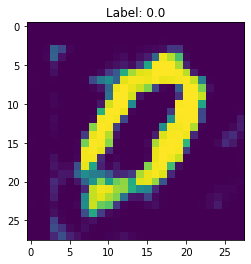

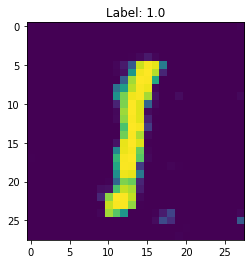

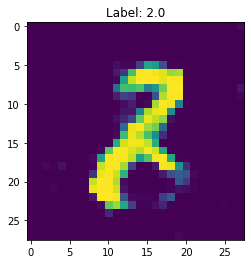

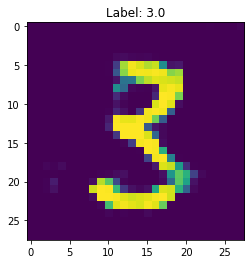

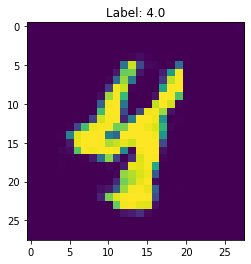

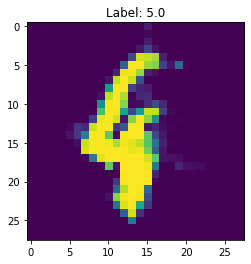

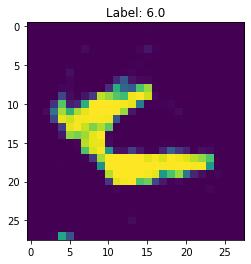

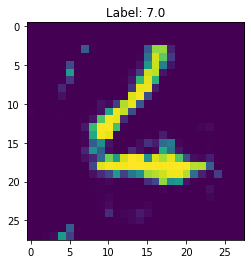

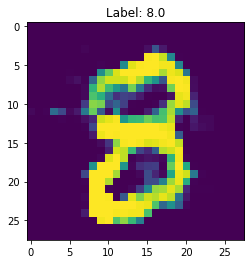

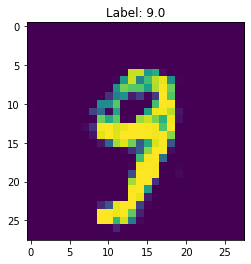

In [13]:
train()

## Auxiliary Classifier GANs

In [14]:
class ACDiscriminator(models.Model):
    
    def __init__(self):
        super(ACDiscriminator, self).__init__()
        
        self.features = models.Sequential([
            layers.Conv2D(16, (3, 3), strides=1, padding="same"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(32, (3, 3), strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(64, (3, 3), strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(128, (3, 3), strides=2, padding="same"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
        ])
        
        self.discriminator = models.Sequential([
            layers.Flatten(),
            
            layers.Dense(1),
            layers.Activation(tf.nn.sigmoid)
        ])
        
        self.classifier = models.Sequential([
            layers.Flatten(),
            
            layers.Dense(10),
            layers.Activation(tf.nn.softmax)
        ])
        
    def call(self, x, training=False):
        features = self.features(x, training=training)
        disc = self.discriminator(features, training=training)
        pred = self.classifier(features, training=training)
        return disc, pred

In [15]:
generator = Generator()
discriminator =  ACDiscriminator()
optimizer = optimizers.RMSprop(learning_rate=ETA)
train_losses = metrics.Mean()
test_losses = metrics.Mean()

In [18]:
def train_step(x, y):
    N = x.shape[0]
    
    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_dis:
        z = tf.random.normal(shape=(N, 128))
        x_fake = generator(z, y, training=True)
        
        d_real, c_real = discriminator(x, training=True)
        d_fake, c_fake = discriminator(x_fake, training=True)
        
        loss_gen = -tf.reduce_mean(tf.math.log(d_fake + 1e-12)) + losses.sparse_categorical_crossentropy(y, c_fake)
        loss_dis = -tf.reduce_mean(tf.math.log(d_real + 1e-12) + tf.math.log(1 - d_fake + 1e-12)) + losses.sparse_categorical_crossentropy(y, c_real)
        
    grads_gen = tape_gen.gradient(loss_gen, generator.trainable_variables)
    grads_dis = tape_dis.gradient(loss_dis, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(grads_gen, generator.trainable_variables))
    optimizer.apply_gradients(zip(grads_dis, discriminator.trainable_variables))
    
    train_losses.update_state(loss_gen + loss_dis)

Epochs 100/100
Train loss: 7.448026180267334


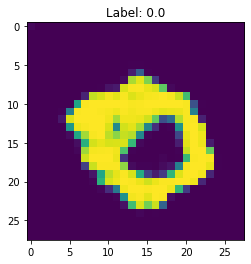

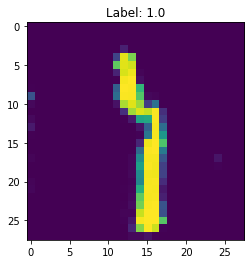

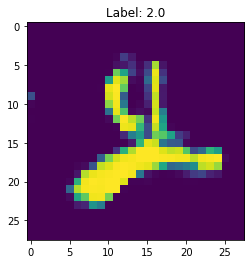

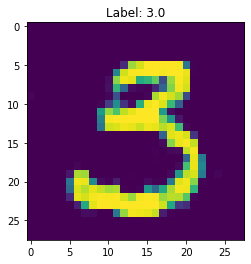

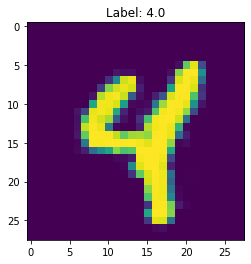

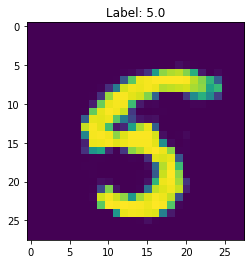

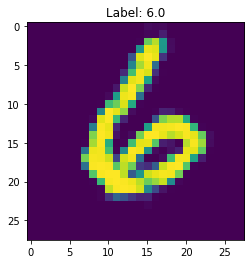

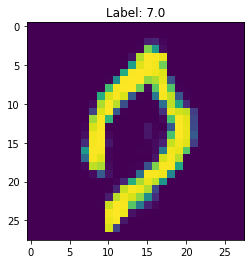

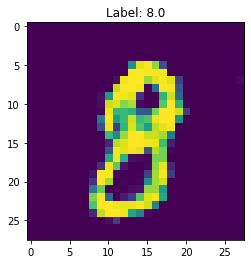

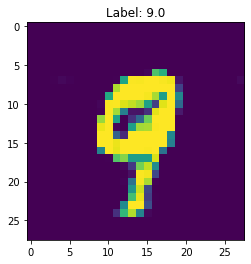

In [19]:
train()